In [2]:
# Import Packages
import pandas as pd # Matrix Operations
import numpy as np # Linear Algebra
import os # OS Functions

# GRAPHING
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.patches as mpatches
# %matplotlib inline

# MACHINE LEARNING
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import manifold


# NATURAL LANGUAGE PROCCESSING (NLP)
import gensim
import gensim.downloader as api
from gensim.models import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# MISC
import distinctipy # Generate n colors
import re # Regex
import random # Random Operations
import string
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

#Color class for formatting outputs
class COLOR:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'



def clean_data(data):
    """Cleaning Data for analysis
    ARGS:
        data: data to clean
    RETURNS:
        none
    """
    # Filtering Data to ensure they accepeted the survey and they are eligible
    data = data[(data['s_eligible'] == "1") & (data['s_intro'] == "1")]
    # Drop columns: 's_eligible', 's_intro' and 4 other columns (That are all NRB Related)
    data = data.drop(columns=['s_eligible', 's_intro', 's_nrb', 's_nrb_residence', 's_nrb_us', 's_nrb_overnight', 's_datayear'])
    # Converting #NULL!'s/None's to "NaN" datatype
    data = data.replace({'#NULL!':np.nan, None:np.nan})
    data = data.apply(pd.to_numeric, errors='ignore')
    return data

def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens
    ARGS:
        text: text to tokenize.
    RETURNS:
        tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

def vectorize(list_of_docs, model, api_model = False):
    """Generate vectors for list of documents using a Word Embedding
    ARGS:
        list_of_docs: list of documents
        model: gensim's word embedding
    RETURNS:
        list of document vectors
    """
    features = [] # List of Features

    for tokens in list_of_docs: # For each set of tokens in the list of docs
        zero_vector = np.zeros(model.vector_size) # Initialize vector
        vectors = [] # List of Vectors
        for token in tokens: # For each token in sentance
            if api_model:
                if token in model: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model[token])
                    except KeyError:
                        continue
            else:
                if token in model.wv: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model.wv[token])
                    except KeyError:
                        continue
        if vectors: # If the List is not empty
            vectors = np.asarray(vectors) # Convert to Array
            avg_vec = vectors.mean(axis=0) # Calculate Mean
            features.append(avg_vec) # Add to Features
        else:
            features.append(zero_vector) # Otherwise add empty vector to Features
    return features

def set_all_seeds(seed = 42, echo = True):
    """Set all seeds
    ARGS: 
        seed: seed to set for repoducibility
        echo: print console logs
    RETURNS:
        none
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    if echo:
        print(COLOR.GREEN, "Seeds have been set to: ", COLOR.BOLD, seed, COLOR.END, sep='')

def get_text_cols(data):
    """Get columns with text answers
    ARGS:
        data: dataframe with columns
    RETURNS:
        list of column names
    """
    return([x for x in data if x.startswith('o')]) #Columns that start with 'o'

# def get_training_data(data, variables):
#     data = data.drop([variables], axis=1).copy()
#     cols = [x for x in data.columns if x.startswith('o')]
#     x_values = data[cols].values.tolist()
#     x_values = np.array(pd.DataFrame(list(chain(*x_values)), columns=['Variable']).dropna().reset_index(drop=True)['Variable'])
#     return(x_values)

# def read_corpus(data, tokens_only = False):
#     for i, line in enumerate(data):
#         tokens = gensim.utils.simple_preprocess(line)
#         if tokens_only:
#             yield tokens
#         else:
#             yield gensim.models.doc2vec.TaggedDocument(tokens, [i])



class NLP():
    """Cluster Class
        Class to hold related models and information regarding text analysis
    """
    def __init__(self, data, model = None, echo = True, reset_seeds=True):
        """INIT

        ARGS:
            data: data to clusterize
            num_clusters: number of clusters to use (if applicable)
            algorithm: algorithm to use
            echo: print console logs

        RETURNS:
            none
        """

        # Storing Variables into class
        self.data = data

        # Booleans to keep track of what operations have been done for helper functions
        self.tokenized = False
        self.dim_reduced = False
        self.clustered = False

        if reset_seeds:
            set_all_seeds(echo=echo)
            
        # Cleaning Data
        temp_frame = pd.DataFrame(np.array(data.copy().dropna()), columns=['variable']) # Convert column to array, drop NaN's
        print(len(temp_frame), 'total samples')
        #TEMPORARY
        custom_stopwords = set(stopwords.words("english")) # Declare stop words
        temp_frame['tokens'] = temp_frame['variable'].map(lambda x: clean_text(x, word_tokenize, custom_stopwords)) # Remove stopwords/uneeded characters
        self.docs = temp_frame['variable'].values # English type values for sentances
        self.tokenized_docs = temp_frame['tokens'].values # Creating tokenized values from english words

        # Creating the Model
        if model == None:
            self.model = Word2Vec(sentences=self.tokenized_docs, vector_size=100, workers=1, seed=seed) # Feeding the tokenized values into the model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.model) # Creating vectors for each doc 
        else:
            self.model = model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.model, api_model=True)
        if echo:
            print('Successfully Tokenized')
        self.tokenized = True

    def dimension_reduce(self, dim_redu_algorithm = 'pca', echo = True, reset_seeds=True):
        """Reduce Dimensions
        ARGS:
            dim_redu_algorithm: algorithm to use to reduce dimensions to two
            echo: console log boolean
        OUTPUTS:
            nothing
        """
        if not self.tokenized:
            print(COLOR.RED, 'ERROR: No tokens found.', COLOR.END, sep='')
            return
        if reset_seeds:
            set_all_seeds(echo=echo)
        self.dim_redu_algorithm = dim_redu_algorithm # Setting the algorithm
        # Dimensionality Reducution
        if self.dim_redu_algorithm == 'pca': # Principal Component Analysis (PCA)
            self.pca = PCA(n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.pca.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'isomap': # Non-Linear - Isometric Mapping (ISOMAP)
            self.iso = manifold.Isomap(n_neighbors=3, n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.iso.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'tsne': # T-distributed Stochastic Neighbor Embedding (TSNE)
            self.tsn = manifold.TSNE(n_components=2, perplexity=50)
            self.datapoints = self.tsn.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'mds': # Multidimensional scaling (MDS)
            self.mds = manifold.MDS(n_components=2, max_iter=10, eps=1)
            self.datapoints = self.mds.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'lle':
            self.lle = manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'spectral_emb':
            self.lle = manifold.SpectralEmbedding(n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        else:
            print(COLOR.RED, COLOR.BOLD, 'ERROR: ', self.dim_redu_algorithm, 'is not an available algorithm', COLOR.END)
            return
        self.datapoints['sentance'] = self.docs # Add the english sentance to the dataframe
        self.X = self.datapoints[['component1', 'component2']].to_numpy() # Convert X/Y components to self.X
        self.dim_reduced = True
        if echo:
            print(COLOR.DARKCYAN, 'Reduced dimensions to 2 using ', COLOR.BLUE, COLOR.BOLD, self.dim_redu_algorithm.upper(), COLOR.END, sep='')
    
    def clusterize(self, cluster_algorithm = 'kmeans', num_clusters = 15, echo=True, reset_seeds=True):
        """Apply Clusters to data
        ARGS:
            cluster_algorithm: algorithm to use to cluterize data
            num_clusters: number of clusters to use (if applicable)
            echo: console log boolean
        OUTPUTS:
            nothing
        """
        if not self.dim_reduced:
            print(COLOR.RED, 'ERROR: Dimensions have not been reduced.', COLOR.END, sep='')
            return
        if reset_seeds:
            set_all_seeds(echo=echo)
        self.num_clusters = num_clusters # Setting number of clusters
        self.cluster_algorithm = cluster_algorithm # Setting cluster algorithm
        # KMEANS
        if (self.cluster_algorithm == 'kmeans'):
            self.km = KMeans(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # MINIBATCH_KMEANS
        if (self.cluster_algorithm == 'kmeans_mb'):
            self.km = MiniBatchKMeans(n_clusters=self.num_clusters, batch_size=500, n_init='auto').fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # DBSCAN
        if (self.cluster_algorithm == 'dbscan'):
            self.db = DBSCAN(eps=0.01, min_samples=20).fit(self.X)
            self.ca = self.db
            self.num_clusters = len(set(self.db.labels_)) - (1 if -1 in self.db.labels_ else 0) # Number of clusters (not including -1, i.e samples that do not fit in a cluster)
            self.datapoints['cluster'] = self.db.labels_
        # SPECTRAL CLUSTERING
        if (self.cluster_algorithm == 'spectral_clustering'):
            self.sc = SpectralClustering(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.sc
            self.datapoints['cluster'] = self.sc.labels_
        # OPTICS
        if (self.cluster_algorithm == 'optics'):
            self.op = OPTICS(min_samples=5).fit(self.X)
            self.ca = self.op
            self.datapoints['cluster'] = self.op.labels_
        self.clustered = True
        if echo:
            print(COLOR.DARKCYAN, 'Clustered using ', COLOR.BLUE, COLOR.BOLD, self.cluster_algorithm.upper(), COLOR.END, sep='')
            print(COLOR.YELLOW, "For n_clusters = ", str(self.num_clusters), COLOR.END, sep='')
            print(COLOR.YELLOW, COLOR.BOLD, f"Silhouette coefficient: {silhouette_score(self.X, self.ca.labels_):0.2f}", COLOR.END, sep='')
            try:
                print(COLOR.YELLOW, COLOR.BOLD, f"Inertia: {self.ca.inertia_:0.3f}", COLOR.END, sep='')
            except:
                pass
    def get_sil_values(self):
        """Get Silhouette Values
        ARGS:
            None
        RETUNRS:
            prints silhouette values
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        sample_silhouette_values = silhouette_samples(self.X, self.ca.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(self.num_clusters):
            cluster_silhouette_values = sample_silhouette_values[self.ca.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )

    def get_cluster_labels(self):
        """Get Cluster Labels
        ARGS:
            None
        RETURNS:
            array of the cluster labels
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        return(np.unique(self.datapoints['cluster']))

    def get_cluster(self, cluster):
        """Get Cluster Information
        ARGS:
            cluster: number of cluster to return
        RETURNS:
            dataframe with a given cluster's information/sentances
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        return(self.datapoints[self.datapoints['cluster'] == cluster])

    def get_clusters(self):
        """Get Clusters
        ARGS:
            None
        RETURNS:
            dataframe with sentances sorted into a column for each cluster
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        df = pd.DataFrame()
        for clust in self.get_cluster_labels():
            # print(self.get_cluster(clust)['sentance'].to_numpy())
            df = pd.concat([df, pd.DataFrame(self.get_cluster(clust)['sentance'].to_numpy(), columns=['cluster_' + str(clust)])], axis=1)
        return(df)

    def viz_clusters(self, cluster_filter = None, figsize = (10, 10), num_annotations = 100, max_char_length = 20, hide_labels=False, hide_legend=False, reset_seeds=True, echo=True):
        """Visualize Clusters
        ARGS:
            figisze: size for figure
            num_annotations: number of ramdom annotations to display on figure
            max_char_length: maximum character length for sentances to be displayed
            hide_labels: boolean to hide labels
            hide_legend: boolean to hide legend
        RETURNS:
            figure of clusters
        """
        # Declaring Figsize
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if reset_seeds:
            set_all_seeds(echo=echo)
        plt.figure(figsize=figsize, dpi=100)

        # Declaring Colors based on Clusters
        color_list = distinctipy.get_colors(self.num_clusters)
        # self.datapoints['colorCode'] = [color_list[x] for x in self.datapoints['cluster']]
        self.datapoints['colorCode'] = [(0,0,0) if x == -1 else color_list[x] for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes unused points the Black cluster)
        self.datapoints['alpha'] = [0.05 if x == -1 else 0.3 for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes Black points more transparent)
        chart_data = self.datapoints.copy()
        
        # Filter by Cluster
        if cluster_filter is not None:
            chart_data = chart_data[chart_data['cluster'].isin(cluster_filter)]
        else:
            cluster_filter = self.get_cluster_labels()

        # Plot datapoints with associated colors/alphas
        plt.scatter(chart_data['component1'], chart_data['component2'], s=50, color=chart_data['colorCode'], alpha=chart_data['alpha'], edgecolors='none')
        # Setting X/Y Labels
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")

        if ~hide_legend:
            patchList = []
            for i, color in enumerate(color_list):
                if i in cluster_filter:
                    data_key = mpatches.Patch(color=color, label='Cluster ' + str(i))
                    patchList.append(data_key)
            plt.legend(handles=patchList, title='Cluster')
        
        # Display rabdom labels
        if ~hide_labels:
            num_annotated = 0
            while (True):
                # Ensures we only annotate x amount of labels
                if (num_annotated == num_annotations):
                    break
                # Grab Random Point
                sent_num = np.random.randint(0, len(chart_data))
                # Ensuring Sentance is less than specified length for readability
                if (len(chart_data.iloc[sent_num]['sentance']) <= max_char_length):
                    plt.annotate(chart_data.iloc[sent_num]['sentance'], (chart_data.iloc[sent_num]['component1'], chart_data.iloc[sent_num]['component2']), size = 7, weight='bold')
                    num_annotated += 1
        # Set Plot Title and Display
        plt.title('dim_redu_alg: ' + self.dim_redu_algorithm.upper() + ' clust_alg: ' + self.cluster_algorithm.upper() + ' ' + str(self.num_clusters) + ' clusters')
        plt.show()

# Importing Data

In [5]:
# Import Data
data = pd.read_parquet(r"C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\nationalData.parquet")
print('Before Filter: ', data.shape)
# data.head()

data_clean = clean_data(data.copy())
print('Post Filter: ', data_clean.shape)
data_clean.head()

Before Filter:  (28082, 346)
Post Filter:  (19977, 339)


,n_IQualtricsID,s_QualtricsLang,o_eligible,s_residence,n_loczip,s_us_int,s_country_int,n_zip_int,s_primary,s_purpose,...,m_act_climb,o_act_climb,m_accom_lodge,n_nightslodge,c_nightslodge,s_npssite,s_sitetype,s_sitesize,s_region,weight_peak
0,R_5ZzD8xdz24Bx17j,EN,NaN,3.0,NaN,1.0,NaN,76107.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
1,R_fvd9VW1Y8umSWOW,EN,NaN,3.0,NaN,1.0,NaN,78130.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
2,R_2Nnte2VxZyBU1Er,EN,NaN,3.0,NaN,1.0,NaN,76643.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,1,1,1,5,0.03
3,R_efmlxcfYDsQNzoJ,EN,NaN,3.0,NaN,1.0,NaN,99349.0,2.0,3.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
4,R_6pb7kqH2oedoEzZ,EN,NaN,3.0,NaN,1.0,NaN,41035.0,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,1,1,1,5,0.03


## Available Text Columns

In [6]:
get_text_cols(data_clean)

['o_eligible',
 'o_comm',
 'o_commstay1',
 'o_commstay2',
 'o_entermode',
 'o_enterwater',
 'o_zipflag',
 'o_zipflag2',
 'o_info_osite',
 'o_info_other',
 'o_infoneed',
 'o_mode_other',
 'o_mode_otherwater',
 'o_type',
 'o_fee',
 'o_parks',
 'o_act_nonmotor',
 'o_act_motor',
 'o_act_waterplay',
 'o_act_other1',
 'o_act_other2',
 'o_act_other3',
 'o_motiv_other',
 'o_prog_other',
 'o_history',
 'o_subjects',
 'o_tech_other',
 'o_itech_other',
 'o_disability',
 'o_like1',
 'o_like2',
 'o_like3',
 'o_least1',
 'o_least2',
 'o_least3',
 'o_expect1',
 'o_expect2',
 'o_qual_other',
 'o_sig',
 'o_gender',
 'o_race',
 'o_langother',
 'o_addl',
 'o_act_climb']

In [7]:
# MODEL TO USE FOR NLP
modelGN300 = api.load('word2vec-google-news-300')
# api.info()

# O_LIKE1

In [8]:
mds_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
mds_model.dimension_reduce('mds')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using MDS


Seeds have been set to: 42


Clustered using SPECTRAL_CLUSTERING
For n_clusters = 10
Silhouette coefficient: 0.20
Seeds have been set to: 42


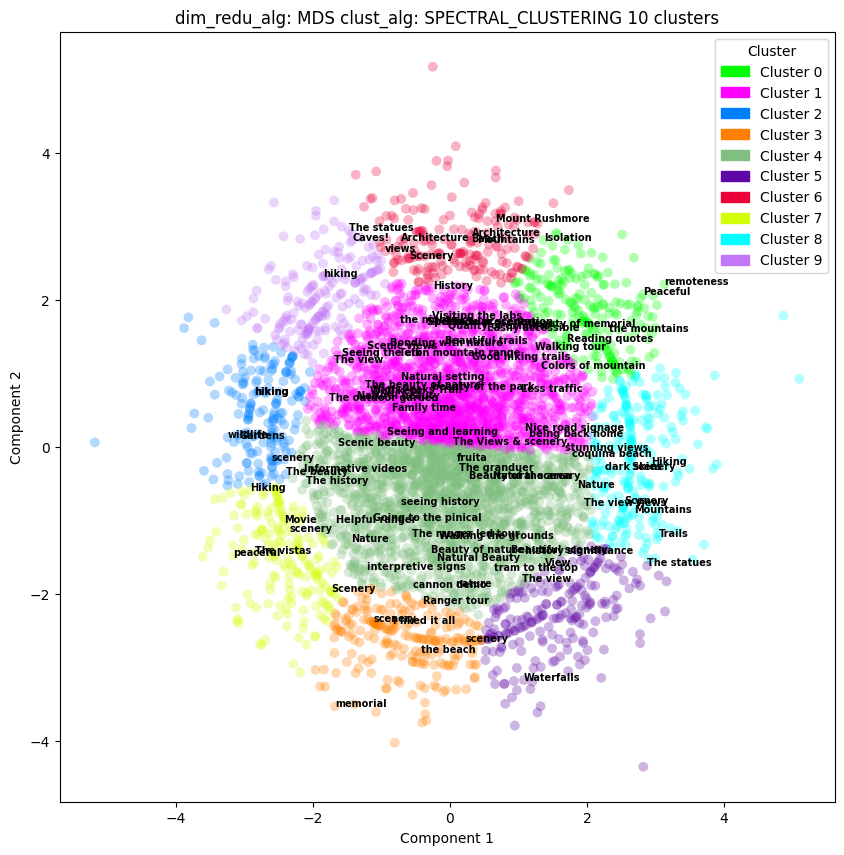

In [9]:
mds_model.clusterize('spectral_clustering', num_clusters=10)
mds_model.viz_clusters()
# mds_model.viz_clusters(cluster_filter=[])

Seeds have been set to: 42


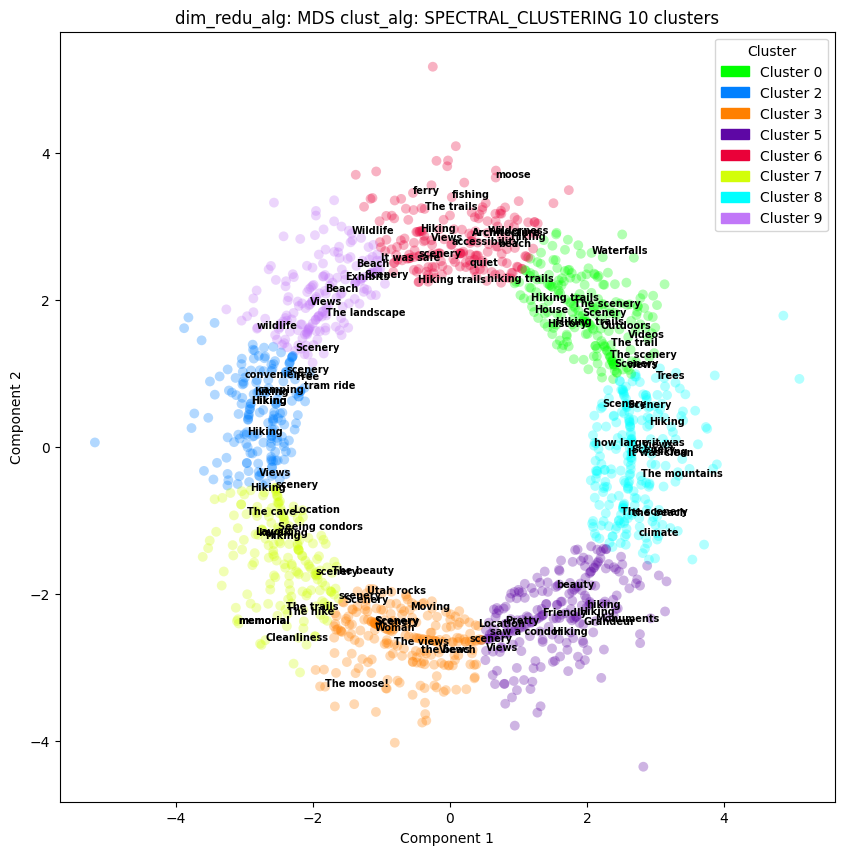

In [10]:
mds_model.viz_clusters(cluster_filter=[0, 2, 3, 5, 6, 7, 8, 9])

Seeds have been set to: 42


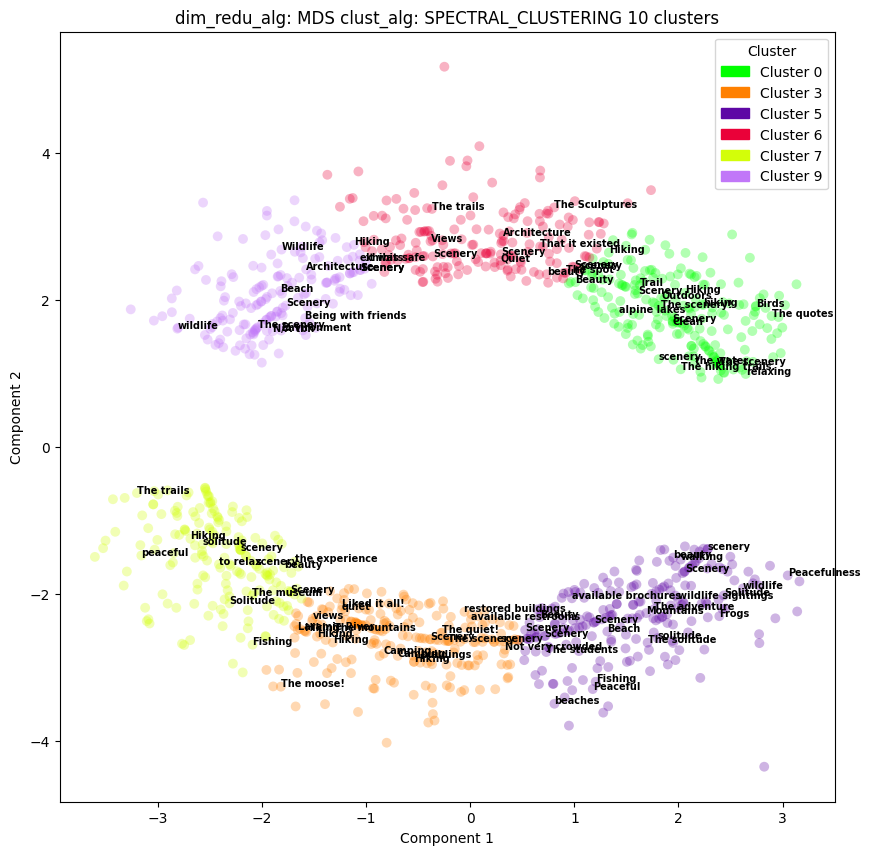

In [11]:
mds_model.viz_clusters(cluster_filter=[0, 3, 5, 6, 7, 9])

Seeds have been set to: 42


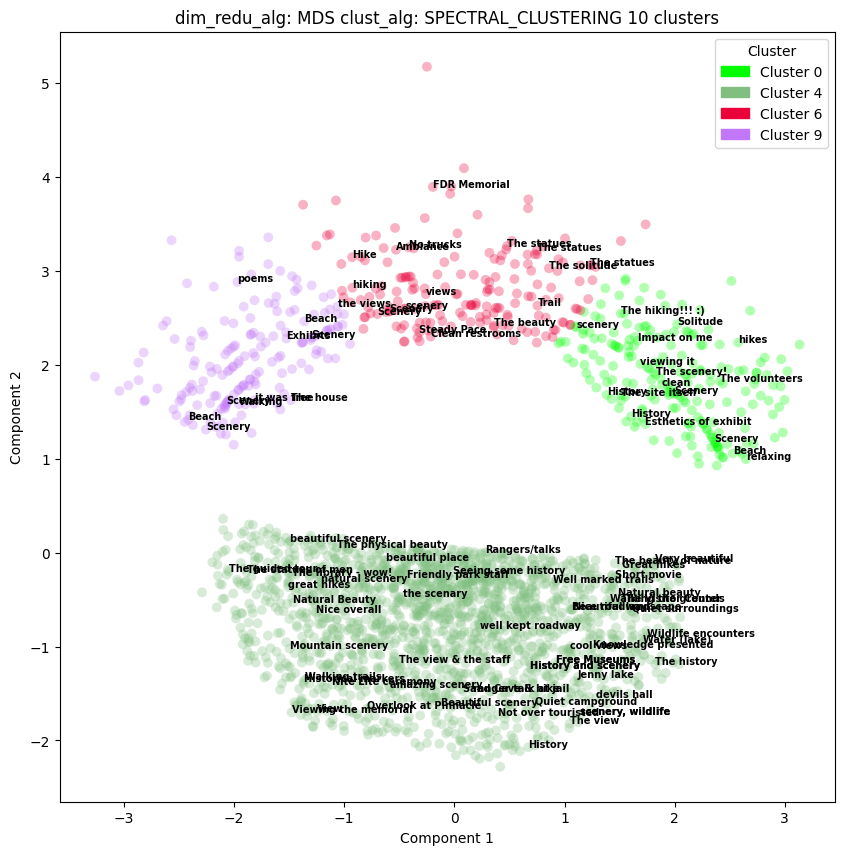

In [12]:
mds_model.viz_clusters(cluster_filter=[9, 6, 0, 4])

In [9]:
lle_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
lle_model.dimension_reduce('lle')

Seeds have been set to: 42
Reduced dimensions to 2 using LLE


Clustered using KMEANS
For n_clusters = 10
Silhouette coefficient: 0.81
Inertia: 0.071


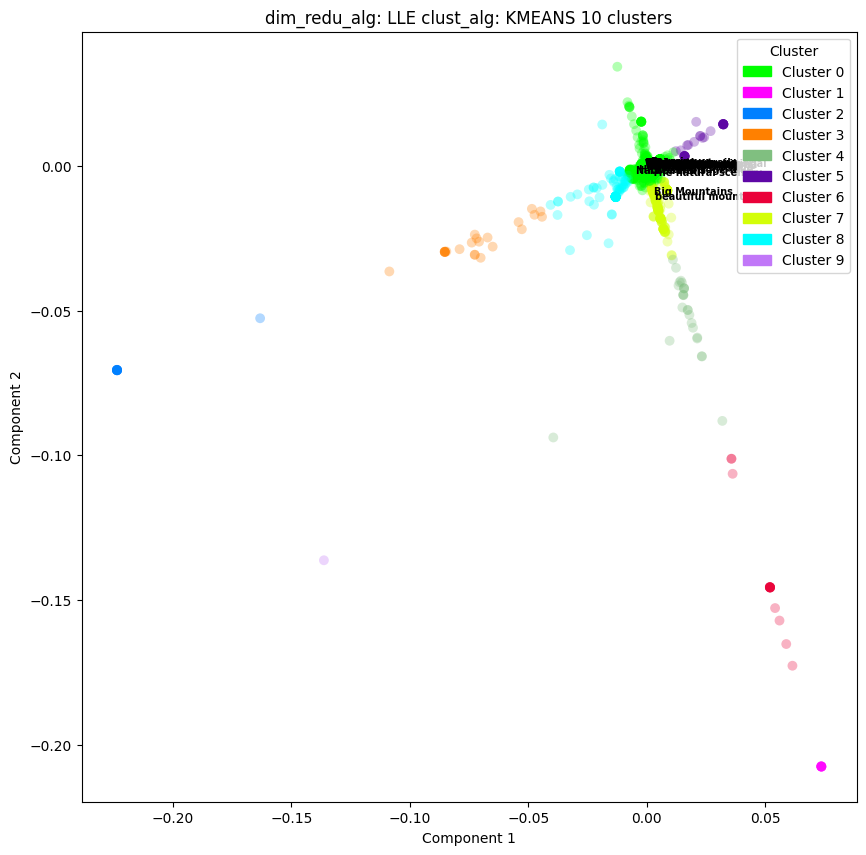

In [10]:
lle_model.clusterize('kmeans', num_clusters=10)
lle_model.viz_clusters()

In [11]:
spect_emb_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
spect_emb_model.dimension_reduce('spectral_emb')

Seeds have been set to: 42
Reduced dimensions to 2 using SPECTRAL_EMB


Clustered using KMEANS
For n_clusters = 10
Silhouette coefficient: 0.55
Inertia: 0.000


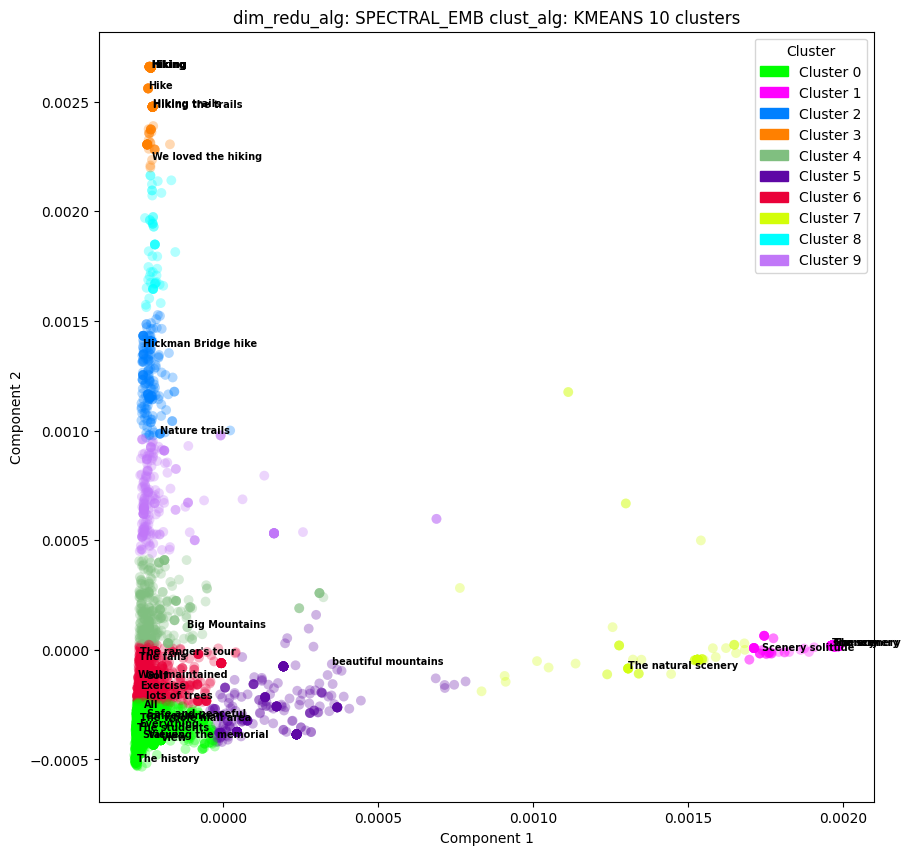

In [12]:
spect_emb_model.clusterize('kmeans', num_clusters=10)
spect_emb_model.viz_clusters()

In [13]:
spect_emb_model.get_clusters()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,great bathrooms,Scenery,Nature/hiking trails,The hiking!!! :),Fossils on the reef hike (with free marker bro...,Solitude,Ranger hospitality and knowledge,The Views & scenery.,Hiking Guadalupe Peak trail,Isolated nature hike
1,Views,The scenery,Nice trails,Hiking,Trail maintenance was great,The landscape,remoteness,The scenery was beautiful,Hiking with family,Clearly marked trails
2,God's creation,Scenery,Moderate difficulty of the Guadalupe Peak hike,hiking,Taking a rest break at the cabin in McKittrick...,Beautiful scenery (and unique),Pratt cabin area and ranger talk,Scenery and walk,Hiking with very few people on the trails,Being in the mountains
3,History of settlement,The scenery,How clean the trails were,Hiking,Devils Hall trail was great,Natural beauty,Beautiful and somewhat different from other parks,The beautiful scenery,Hiking experience,The mountains
4,The natural landscape and geology,Scenery and geology,Great hikes,Hiking,Had a trail we could take the dogs on,The scenery and overall beauty of the Park,The natural beauty of the park,The natural scenery,The hiking and the views,Hiking- a good variety of trails available
...,...,...,...,...,...,...,...,...,...,...
2279,serenity and sense of place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2280,Interesting exhibits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2281,quiet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2282,I enjoyed visiting old homes in Natchex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
pca_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
pca_model.dimension_reduce('pca')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using PCA


Seeds have been set to: 42


Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.43
Inertia: 139.264
Seeds have been set to: 42


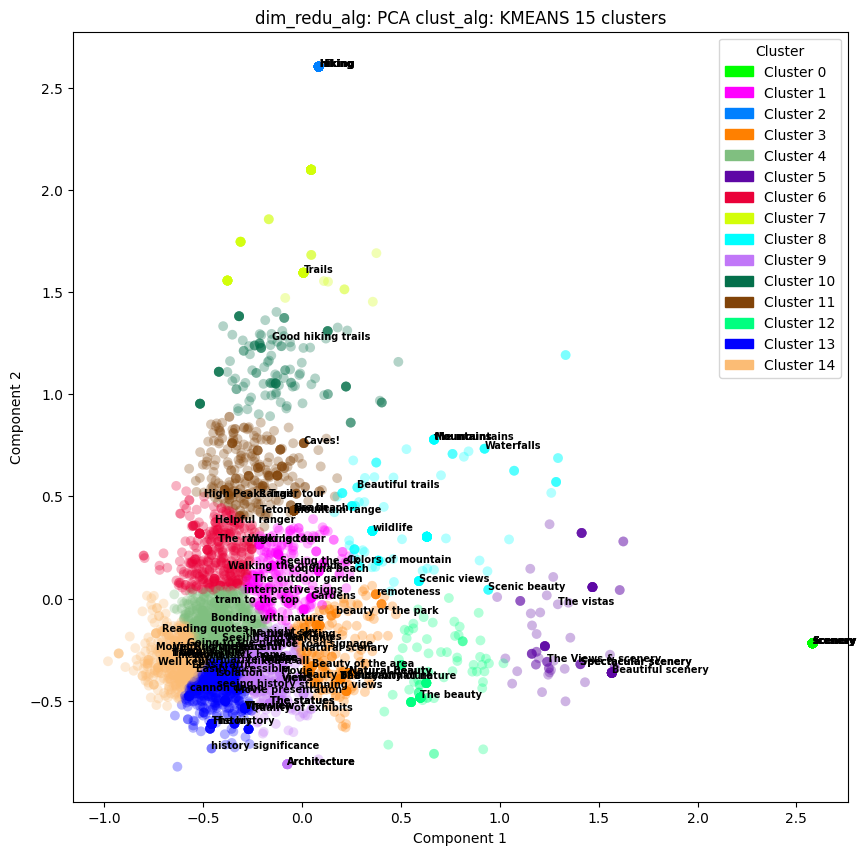

Seeds have been set to: 42


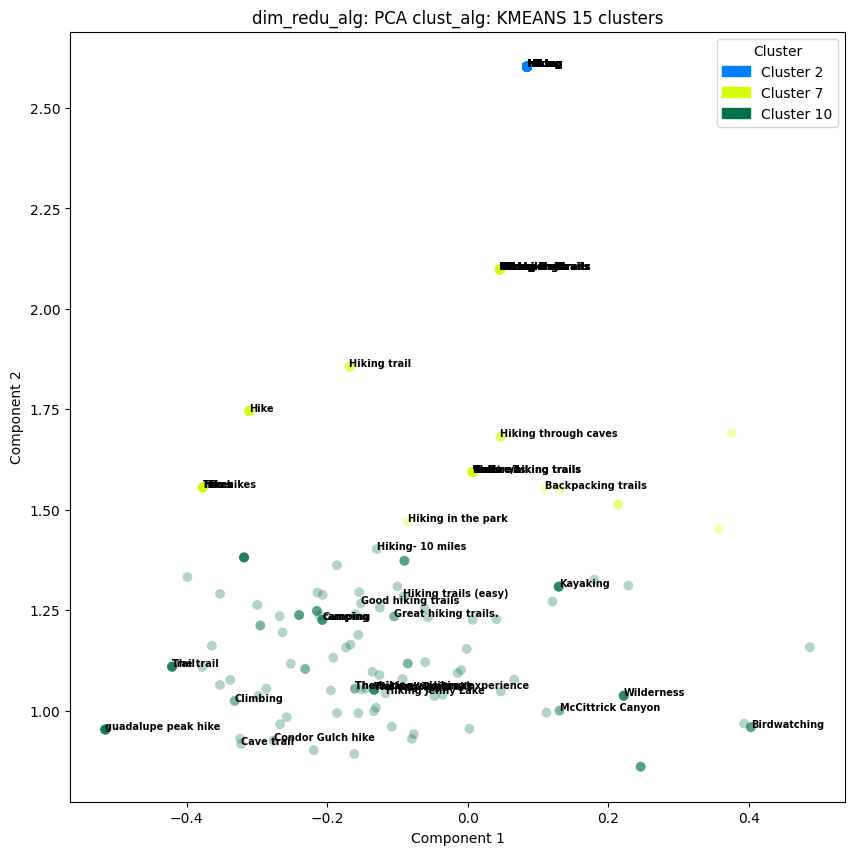

In [57]:
pca_model.clusterize('kmeans', num_clusters=15)
pca_model.viz_clusters(cluster_filter=None)
pca_model.viz_clusters(cluster_filter=[2, 7, 10])

In [18]:
tsne_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
tsne_model.dimension_reduce('tsne')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Reduced dimensions to 2 using TSNE


Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.42
Inertia: 478519.156


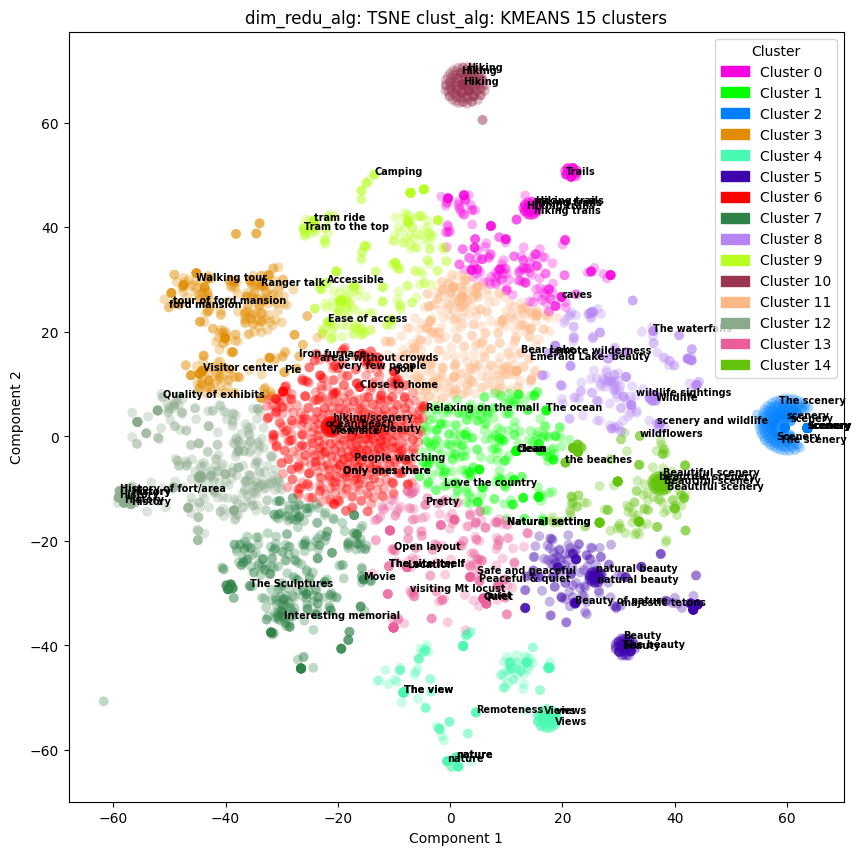

In [20]:
tsne_model.clusterize('kmeans', num_clusters=15)
tsne_model.viz_clusters(num_annotations=100)

In [22]:
tsne_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
tsne_model.dimension_reduce('tsne')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Reduced dimensions to 2 using TSNE


Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.42
Inertia: 929640.000


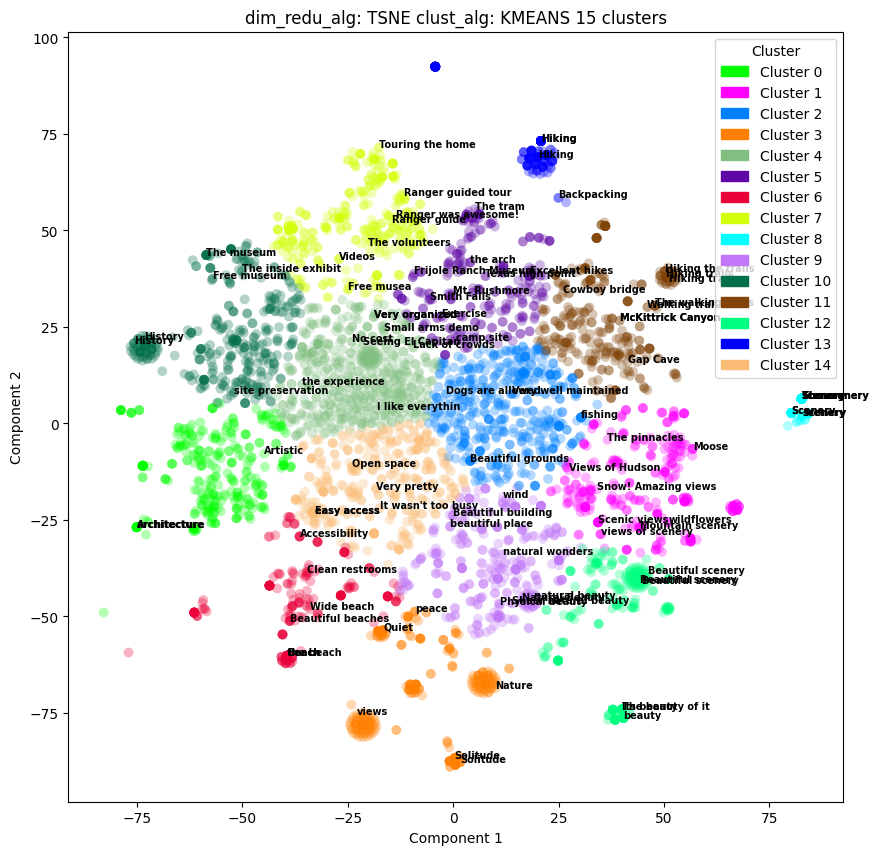

In [23]:
tsne_model.clusterize('kmeans', num_clusters=15)
tsne_model.viz_clusters(num_annotations=100)